In [35]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [79]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def is_wc_permutation(A):
    """
    Check if the given 1D numpy array satisfies the condition:
    After grouping every 3 integers, sorting each group in ascending order
    results in [min(group), min(group)+1, min(group)+2].

    Args:
        A (numpy.ndarray): A 1D numpy array of integers.

    Returns:
        bool: True if all groups satisfy the condition, False otherwise.
    """
    if len(np.unique(A)) != len(A):
        print('Warning: not a proper assignment for water clusters')
    n = len(A)
    if n % 3 != 0:
        raise ValueError("The length of the array must be a multiple of 3.")
    
    groups = [A[i:i+3] for i in range(0, n, 3)]  # Group every 3 integers
    for group in groups:
        sorted_group = sorted(group)
        if sorted_group != [np.min(group), np.min(group) + 1, np.min(group) + 2]:
            print('Warning: not a proper assignment for water clusters')
            return False
    return True

def wc_D(X_A):
    D_A = np.ones((X_A.shape[0], X_A.shape[0]))*10
    for i in range(0, X_A.shape[0], 3):
        D_A[i:i+3, i:i+3] = distance_matrix(X_A[i:i+3], X_A[i:i+3])
    return D_A



In [85]:
def _Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
        molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
        # Basic processing of the molecules
        X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
        X_B, T_B, B_B = otm.tl.process_molecule(molB)
        C = otm.tl.molecule_physchem_distance(T_A, T_B)
        C = np.where(C>0, 1e12, C)
        #D_A = wc_D(X_A)
        #D_B = wc_D(X_B)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                for p in p_list:
                    if D_matrix == 'euclidean':
                        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                    rmsd = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
                    if rmsd < rmsd_best:
                        rmsd_best = rmsd
                        p_best = p
                        P_best = P
                        alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)

        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        is_wc_permutation(optimal_assignment)
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
            print(nameA, nameB, 'Warning: unmatched atom names exist')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD({}+{})'.format(method, D_matrix): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [88]:
data_path = "./DataArbAlign/Water-Clusters"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')
otmol_res = _Experiment(data_path, molecule_pairs, method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,100), p_list=[1])
#print(otmol_res)

2-Cs-1 2-OpenC1 0.31567956283518145
3-UUD 3-UUU 0.30954362705566146
4-Ci 4-S4 0.4939862594397265
5-CA-A 5-CA-B 1.14264144112136
6-BAG 6-BK-1 1.4603230355710173
7-BI1 7-BI2 0.4504250872530827
8-D2d 8-S4 0.37225433462062013
9-D2dDD 9-S4DA 0.36523903291823867
10-PP1 10-PP2 0.3420401608549068
11-551A-1 11-551A-4 0.13688867337895683
12-D2d-1-L 12-D2d-1-R 0.30298019610094923
13-TIP4P 13-TIP5P 1.2612296219175103
14-1 14-2 0.4103188355274388
15-1 15-2 1.2395144839837642
16-TIP4P 16-TIP5P 1.642829236081197
17-TIP4P 17-TIP5P 1.2239892788943478
18-TIP4P 18-TIP5P 1.4156171587095256
19-TIP4P 19-TIP5P 1.4744533088903797
20-TIP4P 20-TIP5P 1.8239127339238268
21-TIP4P 21-TIP5P 1.4601593952507221
25-1 25-2 1.0485929043689564
40-a 40-b 2.217993209849499
60-1 60-2 2.034896830639584
100-1 100-2 1.9015316597105425


In [83]:
otmol_res

,nameA,nameB,RMSD(fgw+euclidean),# atoms,alpha,p,assignment,atomname_diff
0,2-Cs-1,2-OpenC1,0.315697,6,0.088889,1,"[0, 2, 1, 3, 5, 4]",[]
1,3-UUD,3-UUU,0.309563,9,0.011111,1,"[6, 8, 7, 3, 4, 5, 0, 2, 1]",[]
2,4-Ci,4-S4,0.493986,12,0.044444,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",[]
3,5-CA-A,5-CA-B,1.221644,15,0.088889,1,"[3, 4, 5, 12, 13, 14, 6, 8, 7, 9, 10, 11, 0, 2...",[]
4,6-BAG,6-BK-1,1.875729,18,0.088889,1,"[12, 14, 13, 6, 7, 8, 15, 16, 17, 3, 4, 5, 0, ...",[]
5,7-BI1,7-BI2,2.663242,21,0.033333,1,"[18, 19, 20, 12, 14, 13, 9, 10, 11, 15, 16, 17...",[]
6,8-D2d,8-S4,1.999921,24,0.088889,1,"[21, 23, 22, 18, 20, 19, 15, 17, 16, 12, 13, 1...",[]
7,9-D2dDD,9-S4DA,2.171536,27,0.022222,1,"[0, 1, 2, 24, 26, 25, 21, 22, 23, 18, 19, 20, ...",[]
8,10-PP1,10-PP2,2.486645,30,0.022222,1,"[12, 13, 14, 21, 22, 23, 18, 20, 19, 15, 17, 1...",[]
9,11-551A-1,11-551A-4,2.388657,33,0.044444,1,"[3, 5, 4, 27, 29, 28, 6, 7, 8, 21, 23, 22, 15,...",[]


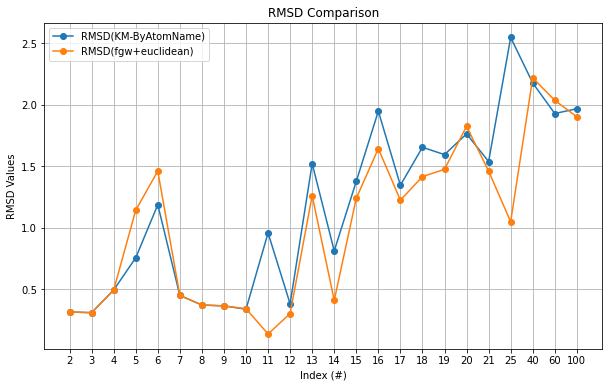

In [89]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')

combined_df = pd.concat([otmol_res, arbalign_res], axis=1)

# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(KM-ByAtomName)", "RMSD(fgw+euclidean)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['#'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['#'])), combined_df['#'])

plt.title("RMSD Comparison")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.legend()
plt.grid(True)

In [ ]:
# %%
# Read the molecules


In [58]:
# Basic processing of the molecules
def wc_D(X_A):
    D_A = np.ones((X_A.shape[0], X_A.shape[0]))*1e6
    for i in range(0, X_A.shape[0], 3):
        D_A[i:i+3, i:i+3] = distance_matrix(X_A[i:i+3], X_A[i:i+3])
    return D_A
#D_A = wc_D(X_A[:6])
#D_B = wc_D(X_B[:6])
#print(D_A)

In [57]:
#print(distance_matrix(X_A[:6], X_A[:6]))

In [63]:
molA = next(pybel.readfile("xyz", "./DataArbAlign/Water-Clusters/13-TIP4P.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/Water-CLusters/13-TIP5P.xyz"))
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
C = otm.tl.molecule_physchem_distance(T_A, T_B)
C = np.where(C>0, 1e12, C)
D_A = wc_D(X_A)
D_B = wc_D(X_B)
alpha_list = np.linspace(0, 0.1, 1000)
p_list = [1]
rmsd_best = 1e10
p_best = None
P_best = None
alpha_best = None
for alpha in alpha_list:
    for p in p_list:
        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method='fgw', alpha=alpha)
        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
        rmsd = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
        if rmsd < rmsd_best:
            rmsd_best = rmsd
            p_best = p
            P_best = P
            alpha_best = alpha
optimal_assignment = np.argmax(P_best, axis=1)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P_best) 
print(RMSD(X_A, X_B_aligned[np.argmax(P_best, axis=1)]))
is_wc_permutation(np.argmax(P_best, axis=1))
if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
    print('Warning: unmatched atom names exist')
plt.show()

2.493901524312154
